# Project Title: Evaluating Dimensionality Reduction for High-Dimensional Image Classification

## Setup & Data Loading

In [367]:
%load_ext cuml.accel

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import cudf
# import cupy as cp
import pandas as pd

SEED = 17
THRESHOLD = 0.9

The cuml.accel extension is already loaded. To reload it, use:
  %reload_ext cuml.accel


In [368]:
df_train = pd.read_csv("fashion-mnist_train.csv")
df_test = pd.read_csv("fashion-mnist_test.csv")

In [369]:
print(f"Train df has shape of {df_train.shape}")
print(f"Test df has shape of {df_test.shape}")

Train df has shape of (60000, 785)
Test df has shape of (10000, 785)


## Data Preprocessing

In [370]:
X_train = df_train.drop(columns="label")
y_train = df_train["label"]

X_test = df_test.drop(columns="label")
y_test = df_test["label"]

In [371]:
from cuml.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Part 1: Unsupervised Reduction with PCA

In [372]:
from cuml.decomposition import PCA

pca = PCA(n_components=None)
pca.fit(X_train_scaled)

Warning(`fit`): As of v0.16, PCA invoked without an n_components argument defaults to using min(n_samples, n_features) rather than 1


PCA()

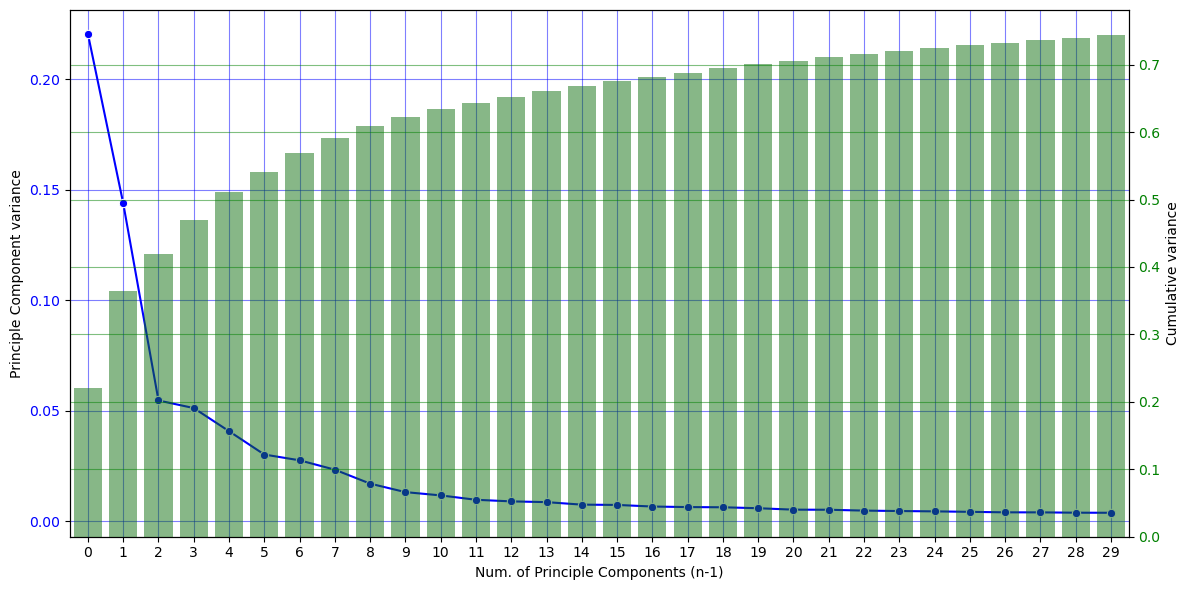

In [373]:
cum_variance = np.cumsum(pca.explained_variance_ratio_)
pca_variance = pca.explained_variance_ratio_

df_pca = pd.DataFrame(
    data={
        "Cumulative Variance": cum_variance,
        "Principle Component Variance": pca_variance,
    }
)

num_components_to_plot = 30
fig, ax1 = plt.subplots(figsize=(12, 6))
line_color = "blue"
bar_color = "green"
sns.lineplot(
    data=df_pca["Principle Component Variance"][:num_components_to_plot],
    marker="o",
    ax=ax1,
    color=line_color,
)
ax2 = ax1.twinx()
sns.barplot(
    data=df_pca["Cumulative Variance"][:num_components_to_plot],
    alpha=0.5,
    ax=ax2,
    color=bar_color,
)
ax1.set_ylabel("Principle Component variance")
ax1.tick_params(axis="y", labelcolor=line_color)
ax2.tick_params(axis="y", labelcolor=bar_color)
ax2.set_ylabel("Cumulative variance")
ax1.set_xlabel("Num. of Principle Components (n-1)")
ax1.grid(alpha=0.5, color=line_color)
ax2.grid(alpha=0.5, color=bar_color)
plt.tight_layout()

In [374]:
thresh_idx = np.where(cum_variance >= THRESHOLD)[0][0]
print(
    f"Elbow point at component 3 with cumulative explained variance of {round(df_pca['Cumulative Variance'][2], 2)}."
)
print(
    f"Component {thresh_idx + 1} above threshold with cumulative explained variance of {round(df_pca.iloc[thresh_idx]['Cumulative Variance'], 2)}."
)

Elbow point at component 3 with cumulative explained variance of 0.42.
Component 137 above threshold with cumulative explained variance of 0.9.


In [375]:
pca_new = PCA(n_components=2)
X_train_pca = pca_new.fit_transform(X_train_scaled)
X_test_pca = pca_new.transform(X=X_test_scaled)

In [376]:
from sklearn.inspection import DecisionBoundaryDisplay


def plot_decision_boundary(X, y, classifier, random_state, n=None):
    total_n = len(X)
    rng = np.random.default_rng(seed=random_state)
    rand_idx = rng.choice(total_n, min(n, total_n), replace=False)
    feature_1, feature_2 = np.meshgrid(
        np.linspace(X[:, 0].min(), X[:, 0].max()), np.linspace(X[:, 1].min(), X[:, 1].max())
    )
    grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
    y_pred = np.reshape(classifier.predict(grid), feature_1.shape)
    display = DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, response=y_pred)

    display.plot()
    display.ax_.scatter(
        X[rand_idx, 0],
        X[rand_idx, 1],
        c=y[rand_idx],
        edgecolor="black",
        alpha=0.7,
        s=40,
    )

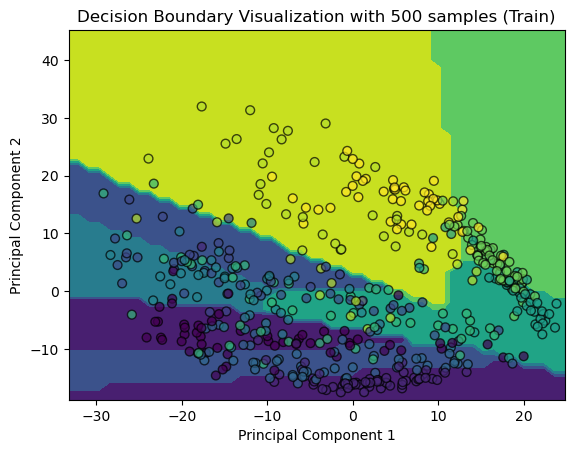

In [377]:
from cuml.linear_model import LogisticRegression

lr_pca = LogisticRegression(max_iter=4000).fit(X_train_pca, y_train)
n_samples = 500
plot_decision_boundary(
    X=X_train_pca, y=y_train, classifier=lr_pca, n=n_samples, random_state=SEED
)
plt.title(f"Decision Boundary Visualization with {n_samples} samples (Train)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

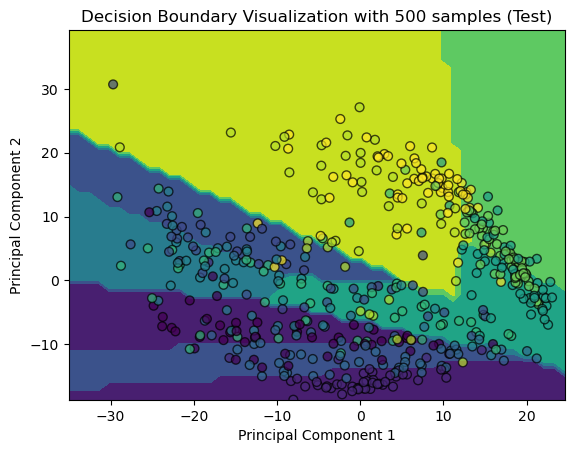

In [378]:
n_samples = 500
plot_decision_boundary(
    X=X_test_pca, y=y_test, classifier=lr_pca, n=n_samples, random_state=SEED
)
plt.title(f"Decision Boundary Visualization with {n_samples} samples (Test)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

## Part 2: Supervised Reduction with LDA

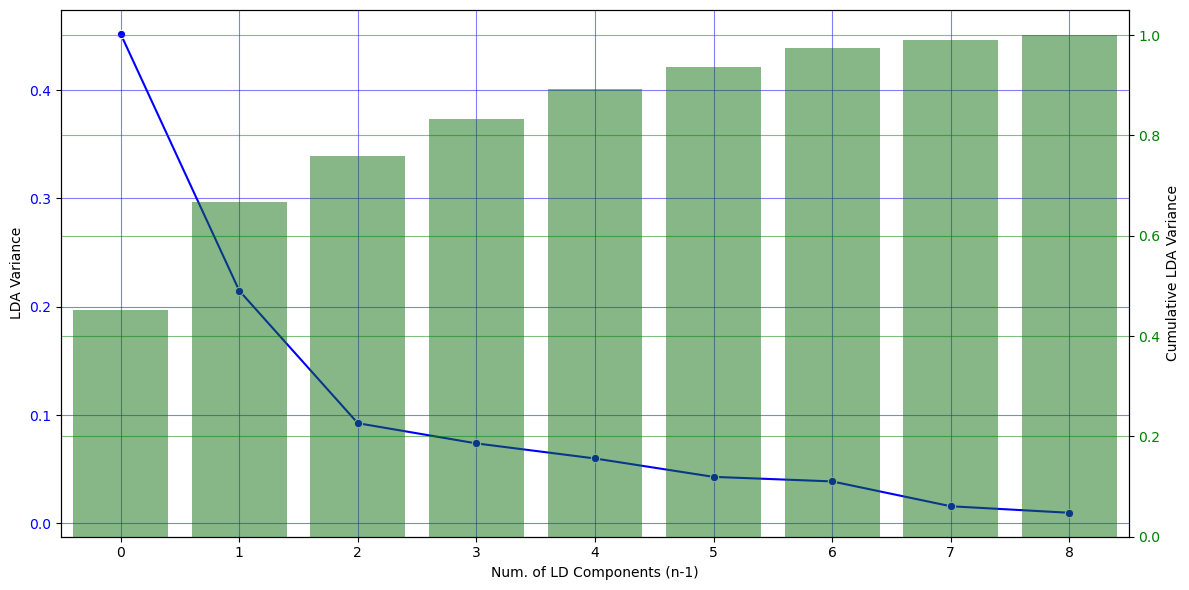

In [379]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=None)
lda.fit(X=X_train_scaled, y=y_train)

lda_variance = lda.explained_variance_ratio_
lda_cum_variance = np.cumsum(lda_variance)

df_lda = pd.DataFrame(
    data={
        "Cumulative LDA Variance": lda_cum_variance,
        "LDA Variance": lda_variance,
    }
)

fig, ax1 = plt.subplots(figsize=(12, 6))
line_color = "blue"
bar_color = "green"
sns.lineplot(
    data=df_lda["LDA Variance"][:num_components_to_plot],
    marker="o",
    ax=ax1,
    color=line_color,
)
ax2 = ax1.twinx()
sns.barplot(
    data=df_lda["Cumulative LDA Variance"][:num_components_to_plot],
    alpha=0.5,
    ax=ax2,
    color=bar_color,
)
ax1.set_ylabel("LDA Variance")
ax1.tick_params(axis="y", labelcolor=line_color)
ax2.tick_params(axis="y", labelcolor=bar_color)
ax2.set_ylabel("Cumulative LDA Variance")
ax1.set_xlabel("Num. of LD Components (n-1)")
ax1.grid(alpha=0.5, color=line_color)
ax2.grid(alpha=0.5, color=bar_color)
plt.tight_layout()

In [380]:
thresh_idx = np.where(lda_cum_variance >= THRESHOLD)[0][0]
print(
    f"Elbow point at component 3 with cumulative explained variance of {round(df_lda['Cumulative LDA Variance'][2], 2)}."
)
print(
    f"Component {thresh_idx + 1} above threshold with cumulative explained variance of {round(df_lda.iloc[thresh_idx]['Cumulative LDA Variance'], 2)}."
)

Elbow point at component 3 with cumulative explained variance of 0.76.
Component 6 above threshold with cumulative explained variance of 0.94.


In [381]:
lda_new = LDA(n_components=2)
X_train_lda = lda_new.fit_transform(X=X_train_scaled, y=y_train)
X_test_lda = lda_new.transform(X=X_test_scaled)

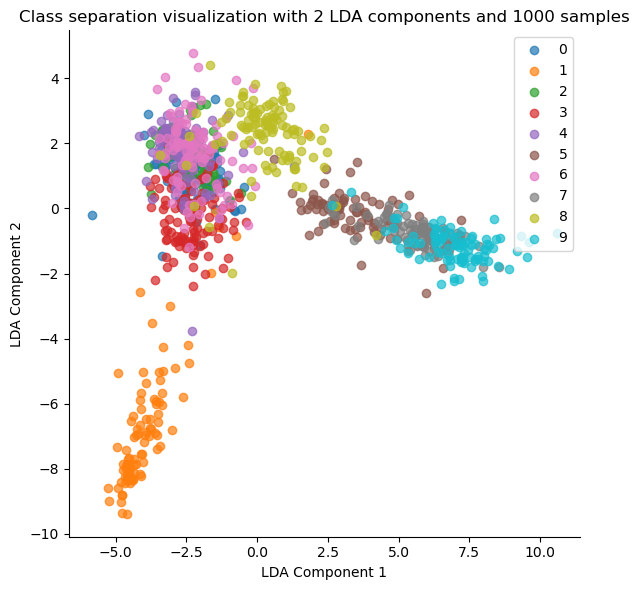

In [382]:
df_lda_new = pd.DataFrame(
    X_train_lda, columns=["LDA Component 1", "LDA Component 2"]
)
df_lda_new["Class"] = y_train

n_samples = 1000
total_n = len(df_lda_new)
rng = np.random.default_rng(seed=SEED)
rand_idx = rng.choice(total_n, min(n_samples, total_n), replace=False)
sns.FacetGrid(df_lda_new.iloc[rand_idx], hue="Class", height=6).map(
    plt.scatter, "LDA Component 1", "LDA Component 2", alpha=0.7
)

plt.title(
    f"Class separation visualization with 2 LDA components and {n_samples} samples"
)
plt.legend(loc="upper right")
plt.tight_layout()

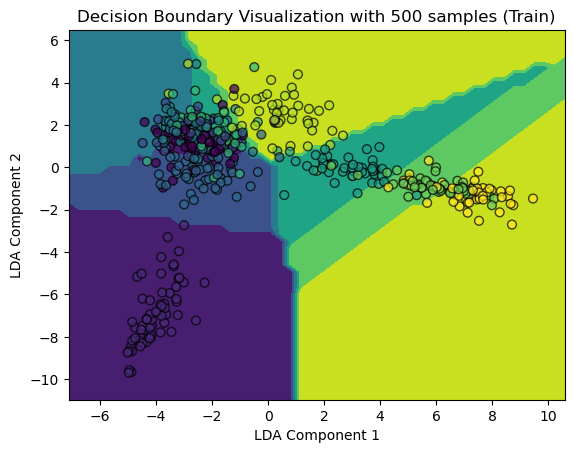

In [383]:
lr_lda = LogisticRegression(max_iter=4000).fit(X_train_lda, y_train)

n_samples = 500
plot_decision_boundary(
    X=X_train_lda, y=y_train, classifier=lr_lda, n=n_samples, random_state=SEED
)
plt.title(f"Decision Boundary Visualization with {n_samples} samples (Train)")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.show()

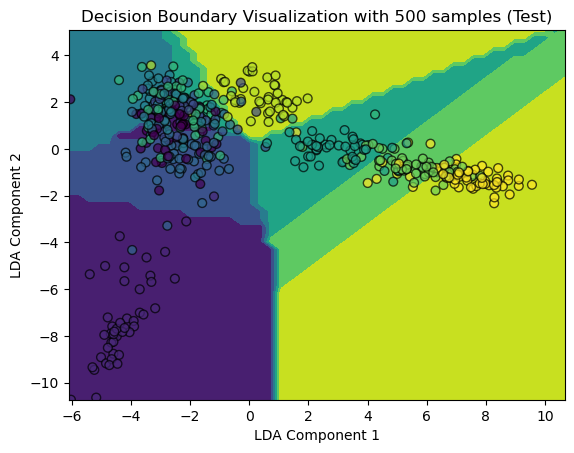

In [384]:
n_samples = 500
plot_decision_boundary(
    X=X_test_lda, y=y_test, classifier=lr_lda, n=n_samples, random_state=SEED
)
plt.title(f"Decision Boundary Visualization with {n_samples} samples (Test)")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.show()

## Part 3: Performance Comparison

In [385]:
from cuml.metrics import accuracy_score, confusion_matrix
from cuml.ensemble import RandomForestClassifier
from cuml.svm import LinearSVC


def calc_perf(X_train, X_test, y_train, y_test, classifier: str, max_iter: int = 1000):
    if classifier == "logreg":
        cfr = LogisticRegression(max_iter=max_iter)
    elif classifier == "randfor":
        cfr = RandomForestClassifier(random_state=SEED)
    elif classifier == "svc":
        cfr = LinearSVC(max_iter=max_iter)
    else:
        raise ValueError("Classifier has to be in ['logreg', 'randfor', 'svc']")
    cfr.fit(X_train, y_train)
    y_pred = cfr.predict(X_test)
    acc_score = accuracy_score(y_true=y_test, y_pred=y_pred)
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    return acc_score, conf_mat

Getting the accuracy score using logreg with the original (scaled) data

In [386]:
%%time
acc_score_lc_ori, conf_mat_lc_ori = calc_perf(
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    y_train=y_train,
    y_test=y_test,
    classifier="logreg",
    max_iter=4000,
)  # max_iter=4000 as 1000 and 2000 both failed to converge

CPU times: user 30 s, sys: 4.86 s, total: 34.8 s
Wall time: 34.8 s


In [387]:
print(
    f"Using logreg on original scaled train dataset has accuracy score of {acc_score_lc_ori}"
)
print(cudf.DataFrame(conf_mat_lc_ori))

Using logreg on original scaled train dataset has accuracy score of 0.8446
     0    1    2    3    4    5    6    7    8    9
0  816    2   20   41    3    3  100    0   15    0
1    2  968    5   16    0    1    7    1    0    0
2   21    6  750   13  111    0   91    0    8    0
3   33   28   15  852   28    2   28    2   11    1
4    1    2   81   32  798    2   77    0    7    0
5    2    4    0    0    1  900    0   60    7   26
6  152    5  106   40   86    0  593    0   17    1
7    0    0    0    0    1   33    0  920    2   44
8    9    2    7   12    4   13   26    6  918    3
9    1    0    0    0    0   16    0   51    1  931


It seems that using logreg with just the scaled data produces good accuracy scores for classes 1, 7, 8, and 9. Class 6 is problematic and gets confused frequently with classes 0 and 2.

Now let's try the same thing but with the PCA-reduced data with 3 (elbow) and 137 (90% cumulative variance) components.

In [388]:
%%time
pca_3 = PCA(n_components=3)
X_train_pca3 = pca_3.fit_transform(X_train_scaled)
X_test_pca3 = pca_3.transform(X=X_test_scaled)
acc_score_lc_pca3, conf_mat_lc_pca3 = calc_perf(
    X_train=X_train_pca3,
    X_test=X_test_pca3,
    y_train=y_train,
    y_test=y_test,
    classifier="logreg",
    max_iter=4000,
)

CPU times: user 952 ms, sys: 103 ms, total: 1.06 s
Wall time: 1.03 s


In [389]:
%%time
pca_137 = PCA(n_components=137)
X_train_pca137 = pca_137.fit_transform(X_train_scaled)
X_test_pca137 = pca_137.transform(X=X_test_scaled)
acc_score_lc_pca137, conf_mat_lc_pca137 = calc_perf(
    X_train=X_train_pca137,
    X_test=X_test_pca137,
    y_train=y_train,
    y_test=y_test,
    classifier="logreg",
    max_iter=4000,
)

CPU times: user 7.91 s, sys: 973 ms, total: 8.89 s
Wall time: 8.7 s


In [390]:
print(
    f"Using logreg on PCA scaled data with 3 components has an accuracy score of {acc_score_lc_pca3}."
)
print(cudf.DataFrame(conf_mat_lc_pca3))
print(
    f"\n\nUsing logreg on PCA scaled data with 137 components has an accuracy score of {acc_score_lc_pca137}."
)
print(cudf.DataFrame(conf_mat_lc_pca137))

Using logreg on PCA scaled data with 3 components has an accuracy score of 0.6073.
     0    1    2    3    4    5    6    7    8    9
0  670   17   18  112   71   17   64    0   30    1
1   26  887   18   59    2    1    5    0    1    1
2   43    2  621    5  178    2  114    0   35    0
3  124  238    6  594   11    5   16    0    1    5
4  140    3  442   80  244    2   73    0   16    0
5    0    0    1    3    0  686    5  213   39   53
6  233    5  278   60  162    5  202    0   55    0
7    0    0    0    0    0  239    0  648    0  113
8    1    5   29   34   16   48   97    2  742   26
9    0    0    0    0    0   10    1  150   60  779


Using logreg on PCA scaled data with 137 components has an accuracy score of 0.8545.
     0    1    2    3    4    5    6    7    8    9
0  814    4   16   46    1    2  104    0   13    0
1    0  968    6   18    0    2    5    1    0    0
2   11    3  765   12  116    0   82    0   11    0
3   32   22   15  884   22    1   22    1    1    

As expected, using only 3 components with a cumulative variance of only 0.42 produced a poor accuracy score of 0.6075. On the other hand, PCA with 137 components had a much better accuracy score of 0.854 while taking 3 times faster to process. It performed exceptionally well for classes 1, 5, 7, 8, 9. On the other hand, it performed just as bad when classifing class 6, confusing it with classes 0 and 2.

Now let's try the same thing but with the LDA-reduced data with 3 (elbow) and 6 (94% cumulative variance) components.

In [391]:
%%time
lda_3 = LDA(n_components=3)
X_train_lda3 = lda_3.fit_transform(X=X_train_scaled, y=y_train)
X_test_lda3 = lda_3.transform(X=X_test_scaled)
acc_score_lc_lda3, conf_mat_lc_lda3 = calc_perf(
    X_train=X_train_lda3,
    X_test=X_test_lda3,
    y_train=y_train,
    y_test=y_test,
    classifier="logreg",
    max_iter=4000,
)

CPU times: user 9.67 s, sys: 728 ms, total: 10.4 s
Wall time: 3.23 s


In [392]:
%%time
lda_6 = LDA(n_components=6)
X_train_lda6 = lda_6.fit_transform(X=X_train_scaled, y=y_train)
X_test_lda6 = lda_6.transform(X=X_test_scaled)
acc_score_lc_lda6, conf_mat_lc_lda6 = calc_perf(
    X_train=X_train_lda6,
    X_test=X_test_lda6,
    y_train=y_train,
    y_test=y_test,
    classifier="logreg",
    max_iter=4000,
)

CPU times: user 9.74 s, sys: 546 ms, total: 10.3 s
Wall time: 3.91 s


In [395]:
print(
    f"Using logreg on LDA scaled data with 3 components has an accuracy score of {acc_score_lc_lda3}."
)
print(cudf.DataFrame(conf_mat_lc_lda3))
print(
    f"\n\nUsing logreg on LDA scaled data with 6 components has an accuracy score of {acc_score_lc_lda6}."
)
print(cudf.DataFrame(conf_mat_lc_lda6))

Using logreg on LDA scaled data with 3 components has an accuracy score of 0.6659.
     0    1    2    3    4    5    6    7    8    9
0  550    0   34  187  105    2  103    1   18    0
1    0  961    0   32    3    0    3    1    0    0
2  132    0  131   54  398    1  273    0   11    0
3  137   14   29  705   43    1   70    0    1    0
4   65    1   71   74  603    2  180    0    4    0
5    0    0    0    1    1  793    0  146   16   43
6  190    0   59  112  237    2  375    0   25    0
7    0    0    0    0    0  154    0  749    1   96
8    3    0    5    5   18   25   12    8  924    0
9    0    0    0    0    0   53    0   79    0  868


Using logreg on LDA scaled data with 6 components has an accuracy score of 0.7777.
     0    1    2    3    4    5    6    7    8    9
0  810    2    8   62    4    2   95    0   17    0
1    1  971    8   16    0    0    3    1    0    0
2   17    1  504   11  264    1  190    0   12    0
3   36   15   14  868   22    2   42    0    1    0


Unsurprisingly, LDA with 6 components produced a better accuracy score compared to 3 components. The individual class accuracies are very similar and consistent with the previous methods.

## Part 4: Nonlinear Visualization with t-SNE

In [396]:
from cuml import TSNE

tsne = TSNE(n_components=2, random_state=SEED)
X_train_tsne = tsne.fit_transform(X=X_train_scaled, y=y_train)
print(f"TSNE transformed dataset has shape {X_train_tsne.shape}.")

# of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
TSNE transformed dataset has shape (60000, 2).


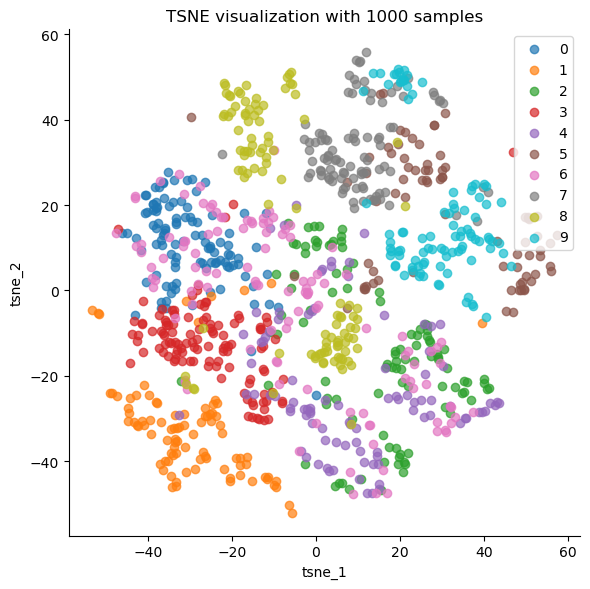

In [399]:
df_tsne = pd.DataFrame(
    data={"tsne_1": X_train_tsne[:, 0], "tsne_2": X_train_tsne[:, 1], "class": y_train}
)

n_samples = 1000
total_n = len(df_tsne)
rng = np.random.default_rng(seed=SEED)
rand_idx = rng.choice(total_n, min(n_samples, total_n), replace=False)
sns.FacetGrid(df_tsne.iloc[rand_idx], hue="class", height=6).map(
    plt.scatter, "tsne_1", "tsne_2", alpha=0.7
)

plt.title(f"TSNE visualization with {n_samples} samples")
plt.legend(loc="upper right")
plt.tight_layout()

## Part 5: Trying out other classifiers (Random Forest Classifier and SVC).

RFC

In [400]:
%%time
acc_score_rfc_pca3, conf_mat_rfc_pca3 = calc_perf(
    X_train=X_train_pca3,
    X_test=X_test_pca3,
    y_train=y_train,
    y_test=y_test,
    classifier="randfor",
)

CPU times: user 3.03 s, sys: 633 ms, total: 3.66 s
Wall time: 906 ms


In [401]:
%%time
acc_score_rfc_pca137, conf_mat_rfc_pca137 = calc_perf(
    X_train=X_train_pca137,
    X_test=X_test_pca137,
    y_train=y_train,
    y_test=y_test,
    classifier="randfor",
)

CPU times: user 5.21 s, sys: 1.5 s, total: 6.7 s
Wall time: 1.57 s


In [402]:
%%time
acc_score_rfc_lda3, conf_mat_rfc_lda3 = calc_perf(
    X_train=X_train_lda3,
    X_test=X_test_lda3,
    y_train=y_train,
    y_test=y_test,
    classifier="randfor",
)

CPU times: user 2.32 s, sys: 725 ms, total: 3.04 s
Wall time: 835 ms


In [403]:
%%time
acc_score_rfc_lda6, conf_mat_rfc_lda6 = calc_perf(
    X_train=X_train_lda6,
    X_test=X_test_lda6,
    y_train=y_train,
    y_test=y_test,
    classifier="randfor",
)

CPU times: user 4.41 s, sys: 1.15 s, total: 5.55 s
Wall time: 1.19 s


In [404]:
print(f"Random forest classifier has the following accuracy scores: \nPCA with 3 components - {acc_score_rfc_pca3}, \nPCA with 137 components - {acc_score_rfc_pca137}, \nLDA with 3 components - {acc_score_rfc_lda3}, \nLDA with 6 components - {acc_score_rfc_lda6}")

Random forest classifier has the following accuracy scores: 
PCA with 3 components - 0.571, 
PCA with 137 components - 0.8603, 
LDA with 3 components - 0.5842, 
LDA with 6 components - 0.7816


In [405]:
print(f"Confusion matrix of random forest classifier with best performing PCA reduced dataset: \n{cudf.DataFrame(conf_mat_rfc_pca137)}")

Confusion matrix of random forest classifier with best performing PCA reduced dataset: 
     0    1    2    3    4    5    6    7    8    9
0  839    1   12   46    5    3   74    1   18    1
1    4  963    5   22    0    2    3    0    1    0
2    8    0  772   12  131    3   63    0   11    0
3   21    6   10  912   31    3   16    0    1    0
4    0    0   57   27  855    1   52    0    8    0
5    0    0    1    1    0  901    0   54    5   38
6  183    0  108   29   84    4  564    0   28    0
7    0    0    0    0    0   46    0  882    1   71
8    1    0    8    4    1    3    7    2  974    0
9    0    0    0    0    0   20    0   39    0  941


Random forest classifier applied on a PCA reduced dataset with 137 components produced slightly better results compared to logreg on the same dataset, but RFC was much faster (1.57s vs 8.7s).

Linear SVC

In [406]:
%%time
acc_score_svc_pca3, conf_mat_svc_pca3 = calc_perf(
    X_train=X_train_pca3,
    X_test=X_test_pca3,
    y_train=y_train,
    y_test=y_test,
    classifier="svc",
)

CPU times: user 143 ms, sys: 28.2 ms, total: 171 ms
Wall time: 167 ms


In [407]:
%%time
acc_score_svc_pca137, conf_mat_svc_pca137 = calc_perf(
    X_train=X_train_pca137,
    X_test=X_test_pca137,
    y_train=y_train,
    y_test=y_test,
    classifier="svc",
)

CPU times: user 986 ms, sys: 168 ms, total: 1.15 s
Wall time: 1.13 s


In [408]:
%%time
acc_score_svc_lda3, conf_mat_svc_lda3 = calc_perf(
    X_train=X_train_lda3,
    X_test=X_test_lda3,
    y_train=y_train,
    y_test=y_test,
    classifier="svc",
)

CPU times: user 83.2 ms, sys: 24.7 ms, total: 108 ms
Wall time: 105 ms


In [409]:
%%time
acc_score_svc_lda6, conf_mat_svc_lda6 = calc_perf(
    X_train=X_train_lda6,
    X_test=X_test_lda6,
    y_train=y_train,
    y_test=y_test,
    classifier="svc",
)

CPU times: user 86.4 ms, sys: 28.8 ms, total: 115 ms
Wall time: 113 ms


In [410]:
print(f"Linear SVC has the following accuracy scores: \nPCA with 3 components - {acc_score_svc_pca3}, \nPCA with 137 components - {acc_score_svc_pca137}, \nLDA with 3 components - {acc_score_svc_lda3}, \nLDA with 6 components - {acc_score_svc_lda6}")

Linear SVC has the following accuracy scores: 
PCA with 3 components - 0.564, 
PCA with 137 components - 0.8478, 
LDA with 3 components - 0.6111, 
LDA with 6 components - 0.7428


In [411]:
print(f"Confusion matrix of SVC with best performing PCA reduced dataset: \n{cudf.DataFrame(conf_mat_svc_pca137)}")

Confusion matrix of SVC with best performing PCA reduced dataset: 
     0    1    2    3    4    5    6    7    8    9
0  811    1   13   72    2    3   78    1   19    0
1    3  971    3   16    1    2    3    1    0    0
2   14    3  752   12  137    0   69    0   13    0
3   33   20   14  882   26    1   22    1    1    0
4    1    2   71   31  819    1   73    0    2    0
5    3    0    0    1    0  915    0   52   10   19
6  175    4  125   47   88    2  536    0   23    0
7    0    0    0    0    0   42    0  910    1   47
8    5    0    7   12    5    9   15    5  941    1
9    0    0    0    0    1   17    0   40    1  941


SVC applied on a PCA reduced dataset with 137 components produced slightly worse results compared to logreg and RFC on the same dataset, but SVC ran the fastest (1.13s).

## Part 6: Final optimized Pipeline

In [427]:
%%time
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    StandardScaler(),
    PCA(n_components=137),
    RandomForestClassifier(random_state=SEED),
    )

pipe.fit(X=X_train, y=y_train)
y_pred = pipe.predict(X=X_test)

CPU times: user 5.21 s, sys: 1.79 s, total: 6.99 s
Wall time: 2.44 s


---

## Summary & Final Thoughts

This project was a fantastic hands-on exploration of dimensionality reduction. The main takeaway for me was seeing the theory in action: I started with a complex dataset of 784 features and were able to get slightly better performance using a Random Forest model with just 137 PCA components. That's a reduction of over 80% in data complexity for a boost in accuracy.

The t-SNE visualization was also a highlight. Even though it's not a classification tool, it did a surprisingly good job of clustering similar clothing items together, which visually confirmed that there were underlying patterns in the data for our models to find.

Overall, this chapter showed me that "more data" isn't always better. By intelligently reducing features, models can be built that are not only faster but also more robust. The fact that the simpler model performed better suggests that PCA helped filter out some of the noise from the original dataset, allowing the classifier to focus on the most important signals.